### DDW - Data Acquisition - Web Crawler/Scraper

Rozhodla jsem se získávat data nahraných plachtařských letů z webu CPSka.cz (https://www.cpska.cz/public/index3.php)
Jelikož cílem je posléze získat informace hlavně o četnosti letů v daných dnech na různých místech (pro odhad kvality letovch podmínek), nejdůležitějšími údaji jsou datum, délka a rychlost letu (příp. typ) a souřadnice startu a cíle. Mimo tyto jsem stahovala i další zajímavé údaje, které by se časem mohly hodit.

- typ letadla
- imatrikulaci (unikátni číslo letadla)
- jméno pilota
- domovský klub
- datum letu
- délka letu
- rychlost
- typ letu
- tvar letu
- souřadnice a kódy počátečních a konečných letišť

Web CPS má jednoduchou nicméně nejednotnou strukturu, na problémy s timeoutem nebo odepřením přístupu jsem nenarazila.
Zarazilo mě až kódování windows-1250, které bylo nutné explicitně nastavit.

Stáhla jsem celkem informace z 1010 letů, které jsem pro kontrolu uložila ve formátu JSON, nicméně pro další operace se mi hodí více flat file, pandas data frame nebo csv soubor, tudíž jsem JSON strukturu zploštila do jednovrstvého listu s údaji o letech.

Data jsem stahovala a ukládala v batchi po 100 letech tak, abych v případě výpadku nebo chyby všechno neztratila, nakonec jsem je spojila do jednoho velkého csv souboru.

Vylepšit by se určitě dalo využívání linků nalezených přímo na stránkách - takto využívám link vedoucí na stránku datumu posledního přidaného letu. Na varietách jsem si zbytek url (až na id) dopsala ručně.


In [3]:
### Imports
import numpy as np
import pandas as pd

import json
import requests
from bs4 import BeautifulSoup

In [4]:
def innerHTML(element):
    """Returns the inner HTML of an element as a UTF-8 encoded bytestring"""
    return element.encode_contents().decode("utf-8",'ignore')

def getBase():
    return "https://www.cpska.cz/public/"

In [5]:
#get most recent upload
def get_highest_id(url, headers):
    id = 0
    print("Crawling date page: "+url)
    source = requests.get(url, headers=headers)
    soup = BeautifulSoup(source.text, "html.parser")
    obsah = soup.findAll('div', {'id':'obsah'})[0]
    rows = obsah.findAll('tr', href=False)[2:]
    ids = []
    for row in rows:
        flight_info = row.findAll('td', href=False)[10]
        flight_link = flight_info.findAll('a', href=True)[0]
        if(flight_link):
            link = flight_link['href']
            print("FLight Link: "+link)
            flight_id = link.split('id=')[1]
            print(flight_id)
            ids.append(flight_id)
    id = max(ids)
    print(ids)
    print("Chosen: "+id)
    return id
    
#get most recent date
def get_last_flight(page, headers):
    url = page+'?lpg=sezlet'
    print("Crawling flights page: "+url)
    source = requests.get(url, headers=headers)
    soup = BeautifulSoup(source.text, "html.parser")
    #First row with flight to get the most recent date
    row = soup.findAll('tr', href=False)[2]
    last_date = row.findAll('td', {'class':'cllDatum'}, href=False)[0]
    date = innerHTML(last_date.find('a', href=True))
    datelink = last_date.find('a', href=True)
    print(datelink['href'])
    print("Date of last added flight: "+date)
    return get_highest_id((getBase()+datelink['href']), headers)

In [6]:
def get_airport(s):
    a = s.split(') ')[1].split('(')[0]
    #print(a)
    if(len(a) != 4 or a[1] == '@'):
        return np.nan
    else:
        return a[:4]
    
#scrape coordinates from point log page
def get_coordinates(page, headers, flight):
    url = page+'&rezim=varianty'
    check = requests.head(url, headers=headers)
    if(check.ok):
        coordinates= {}
        source = requests.get(url, headers=headers)
        source.encoding = 'cp1250'
        soup = BeautifulSoup(source.text, "html.parser")
        points = soup.findAll('div', {'class': 'tratbod'})
        if(len(points) < 1):
            flight['coordinates'] = np.nan
            return flight
            
        first_point = points[0]
        last_point = points[-1]
        coordinates['start'] = innerHTML(first_point.findAll('div', {'class':'nazev'})[0]).split('(')[1].split(' ')[0]
        coordinates['finish'] = innerHTML(last_point.findAll('div', {'class':'nazev'})[0]).split('(')[1].split(' ')[0]
        coordinates['startAirport'] = get_airport(innerHTML(first_point.findAll('div', {'class':'nazev'})[0]))
        coordinates['finishAirport'] = get_airport(innerHTML(first_point.findAll('div', {'class':'nazev'})[0]))
        flight['coordinates'] = coordinates
    else:
        flight['coordinates'] = np.nan
        
        
    return flight


def get_flight(page, headers):
    flight = {}
    pilot = {}
    glider = {}
    
    source = requests.get(page, headers=headers)
    # fixed encoding since most html pages on this web are windows-1250 encoded
    source.encoding = 'cp1250'
    #print("Crawling "+page)
    soup = BeautifulSoup(source.text, "html.parser")

    #side_panel with most valuable information
    side_panel = soup.findAll('div', {'id':'right'})[0]
    #flight date
    flight['date'] = innerHTML(side_panel.findAll('a')[0])
    
    #glider
    side_panels = side_panel.findAll('div', {'class':'panel_lt'})
    glider_panel = side_panels[0]
    glider_h2 = glider_panel.findAll('h2')[0]
    glider['type'] = innerHTML(glider_h2.findAll('a', href=True)[0])
    glider_im = innerHTML(glider_h2).split('</a>')[1]
    glider['immatriculation'] = glider_im[2:-1]

    
    #pilot panel
    pilot_panel = side_panels[1]
    pilot['name'] = innerHTML(pilot_panel.findAll('div',{'class':'jmeno'})[0])
    pilot['club'] = innerHTML(pilot_panel.findAll('div',{'class':'aeroklub'})[0])
    
    #flight info
    flight['pilot'] = pilot
    flight['glider'] = glider
    flight_panel = side_panels[2]
    flight['distance'] = innerHTML(flight_panel.findAll('h1')[0])[:-3]
    flight['speed'] = innerHTML(flight_panel.findAll('h2')[0])[:-5]
    flight['shape'] = (innerHTML(flight_panel.findAll('p')[0])).split(':')[1][1:]
    flight['type'] = (innerHTML(flight_panel.findAll('p')[1])).split(':')[1][1:]

    for p in flight_panel.findAll('p'):
        header = innerHTML(p.findAll('b')[0])
        if('let' in header):
            flight['competition'] = 1
            break
        else:
            flight['competition'] = 0
        
    #flight start and finish coordinates and airport codes
    flight = get_coordinates(page, headers, flight)
    return flight


In [7]:
def mycrawler(page, headers, pages_count, start):
    crawled=[]
    # get upper bound from table, if start is unknown, take most recent flight added to website
    if(start == 0):
        upper_bound = get_last_flight(page, headers)
    else:
        upper_bound = start
    lower_bound = int(upper_bound) - int(pages_count)
    count = int(upper_bound)
    
    #scrape pages_count flights
    while(count > lower_bound):
        flight_url = page+'?lpg=zobraz_let&let_id='+str(count)
        check = requests.head(flight_url, headers=headers)
        #print(check.ok)
        if(check.ok):
            source = requests.get(flight_url, headers=headers)
            soup = BeautifulSoup(source.text, "html.parser")
            labels = (soup.findAll('div', {'id':'obsah'})[0]).findAll('label')
            if(len(labels) > 0):
                label = innerHTML(labels[0])
                if('nebyl nalezen' in label):
                    print("Flight "+str(count)+" not found")
                    lower_bound -= 1
                    count -= 1
                    continue
            flight_info = get_flight(flight_url, headers)
            crawled.append(flight_info)
        else:
            print("Invalid flight_id")
            lower_bound -= 1
        count -= 1
        
    #return scraped data and also last flight ID -> which will be start of next set
    return crawled, count

In [8]:
# function loads and displays data in JSON format
"""
Example of flight data in JSON format:
   {
      "competition": 0,
      "coordinates": {
         "finish": "49'17'133N,17'24'950E",
         "finishAirport": "LKKM",
         "start": "49'17'133N,17'24'950E",
         "startAirport": "LKKM"
      },
      "date": "06.09.2018",
      "distance": "176.6",
      "glider": {
         "immatriculation": "OK-8181",
         "type": "Std. Cirrus"
      },
      "pilot": {
         "club": "Holešov",
         "name": "Mára Vala"
      },
      "shape": "polygon s 5OB",
      "speed": "57.68",
      "type": "rychlostní let se změnou tratě za letu"
   }
"""
def print_json(data):
    dataJson = json.dumps(data)
    str_p = ''.join(dataJson)
    j = json.loads(str_p, encoding="utf-8")
    print(json.dumps(j, indent=3, sort_keys=True, ensure_ascii=False))

In [9]:
# function flattens multilevel JSON structure into 1 level -- for tables and csv purposes
def flatten(data):
    flat = []
    for flight in data:
        new = {}
        new['competition'] = flight['competition']
        new['date'] = flight['date']
        new['distance'] = flight['distance']
        new['shape'] = flight['shape']
        new['speed'] = flight['speed']
        new['type'] = flight['type']
        new['pilotName'] = flight['pilot']['name']
        new['pilotClub'] = flight['pilot']['club']
        new['gliderType'] = flight['glider']['type']
        new['gliderImat'] = flight['glider']['immatriculation']
        if(flight['coordinates'] != np.nan):
            #print(flight['coordinates']['start'])
            new['startCoords'] = flight['coordinates']['start']
            new['finishCoords'] = flight['coordinates']['finish']
            new['startPort'] = flight['coordinates']['startAirport']
            new['finishPort'] = flight['coordinates']['finishAirport']
        else:
            new['startCoords'] = np.nan
            new['finishCoords'] = np.nan
            new['startPort'] = np.nan
            new['finishPort'] = np.nan
        flat.append(new)
    return flat

In [10]:
def scrape_and_save(start, page_count, filename, prtJson=False):
    page = 'https://www.cpska.cz/public/index3.php'
    headers= {  "User-Agent": "DDW",
            #"Upgrade-Insecure-Requests": "1",
            "Content-Encoding": "windows-1250",
            "Accept": "text/html"}
    data, last_id = mycrawler(page, headers, page_count, start)
    if(prtJson):
        print_json(data)
        with open('./../results/json_flights_'+str(start)+'.json', 'w') as outfile:
            json.dump(data, outfile)
    tab = pd.DataFrame(flatten(data))
    tab.to_csv('./../results/'+filename+"_"+str(start)+'.csv', sep=';')
    print("Saved: "+filename+"_"+str(start)+'.csv')
    return last_id

In [ ]:
start = 0
#scraping flights in portions of 100, total of 1000 flights in this go
for i in range(0,2):
    start = scrape_and_save(start, 10, 'flights', True) #change to True for JSON data dump after each set

### Concatenating all csv files

In [58]:
import glob
all_files = glob.glob("./../results/flights*.csv")
print("Number of sets scraped: "+str(len(all_files)))
all_flights = pd.DataFrame()
flights = []
for file in all_files:
    flight = pd.read_csv(file, sep=';')
    flights.append(flight)
    
all_flights = pd.concat(flights, axis=0)
all_flights.drop(columns=["Unnamed: 0"], inplace=True)
all_flights.to_csv('./../results/all_flights.csv', sep=';')

Number of sets scraped: 10


In [70]:
selection =  all_flights.iloc[:]
print(selection.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   competition   1000 non-null   int64  
 1   date          1000 non-null   object 
 2   distance      1000 non-null   float64
 3   finishCoords  1000 non-null   object 
 4   finishPort    79 non-null     object 
 5   gliderImat    976 non-null    object 
 6   gliderType    1000 non-null   object 
 7   pilotClub     1000 non-null   object 
 8   pilotName     1000 non-null   object 
 9   shape         1000 non-null   object 
 10  speed         1000 non-null   float64
 11  startCoords   1000 non-null   object 
 12  startPort     79 non-null     object 
 13  type          1000 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 117.2+ KB
None


<AxesSubplot:>

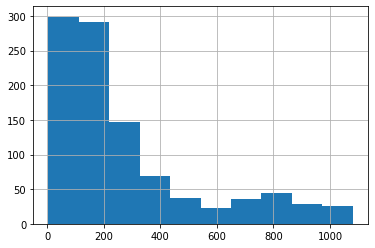

In [60]:
selection.distance.hist()

In [61]:
print("Most frequently used plane:", selection.gliderImat.mode()[0])
print("Most frequent pilot:", selection.pilotName.mode()[0])

Most frequently used plane: OK-7393
Most frequent pilot: Vojtěch Hájek


In [69]:
frequent_flyer = selection.loc[selection.pilotName == selection.pilotName.mode()[0]].copy()
frequent_flyer.loc[:,"datetime"] = pd.to_datetime(frequent_flyer.date, format='%d.%m.%Y')
print("Most frequent pilot flew:", int(frequent_flyer.distance.sum()), "km, between dates",frequent_flyer.datetime.min(), "and", frequent_flyer.datetime.max())
print("His most commont flight shape was:", frequent_flyer["shape"].mode()[0])

Most frequent pilot flew: 7072 km, between dates 2018-10-26 00:00:00 and 2019-03-02 00:00:00
His most commont flight shape was: polygon s 5OB


In [27]:
print(frequent_flyer[["date", "distance", "pilotName", "gliderImat"]])

          date  distance      pilotName gliderImat
24  02.03.2019     269.8  Vojtěch Hájek     VH-GKC
25  01.03.2019     311.1  Vojtěch Hájek     VH-GFV
26  28.02.2019     114.6  Vojtěch Hájek     VH-GFV
27  27.02.2019     173.5  Vojtěch Hájek     VH-CQO
29  26.02.2019     318.5  Vojtěch Hájek     VH-WVS
30  21.02.2019     328.4  Vojtěch Hájek     VH-WVS
34  14.02.2019     315.1  Vojtěch Hájek     VH-GFV
38  08.02.2019     151.5  Vojtěch Hájek     VH-WVS
43  31.01.2019     518.9  Vojtěch Hájek     VH-GFV
46  29.01.2019     384.0  Vojtěch Hájek     VH-GFV
48  28.01.2019     110.0  Vojtěch Hájek     VH-GOC
52  25.01.2019     244.6  Vojtěch Hájek     VH-GKC
55  24.01.2019     369.3  Vojtěch Hájek     VH-GFV
58  22.01.2019     343.5  Vojtěch Hájek     VH-GKC
66  18.01.2019     129.0  Vojtěch Hájek     VH-GOC
70  17.01.2019     301.4  Vojtěch Hájek     VH-GKC
71  17.01.2019     160.0  Vojtěch Hájek     VH-GKC
87  10.01.2019     335.3  Vojtěch Hájek     VH-GKC
88  10.01.2019     236.7  Vojtě